In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

os.chdir('/content/drive/MyDrive/Seed_Classification_4_varieties/crease_down')
os.getcwd()


'/content/drive/MyDrive/Seed_Classification_4_varieties/crease_down'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn.over_sampling as oversample
from model import *
from train_eval import *
import torch
from torchsummary import summary
import torch.optim as optim
import pickle
from sklearn.metrics import confusion_matrix, classification_report


In [4]:
# re-structuring data for training machine-learning model
# combining (train, validation) then applying balancing techniques

if not os.path.exists('Data/combined_df_tr_imbalanced.csv'):

    df_tr = pd.read_csv('Data/df_tr_imbalanced.csv')
    df_val = pd.read_csv('Data/df_val.csv')

    df_train = pd.concat([df_tr, df_val], axis=0)
    df_train = df_train.reset_index(drop=True)
    df_train.to_csv(f'Data/combined_df_tr_imbalanced.csv', index=False)
    print(df_train.shape)

    # apply smote
    X, y = df_train.iloc[:, :-1], df_train.iloc[: , -1]


    # applying smote
    oversampler = oversample.SMOTE()
    X_smote, Y_smote = oversampler.fit_resample(X, y)

    df_tr_smote = pd.concat([X_smote, Y_smote], axis=1)
    df_tr_smote.to_csv('Data/combined_df_tr_smote.csv', index = False)

    # applying Adasyn
    oversampler = oversample.ADASYN()
    X_adasyn, Y_adasyn = oversampler.fit_resample(X, y)

    df_tr_adasyn = pd.concat([X_adasyn, Y_adasyn], axis=1)
    df_tr_adasyn.to_csv('Data/combined_df_tr_adasyn.csv', index = False)


## Data-Processing

In [5]:
if not os.path.exists('Data/df_tr_smote.csv'):
  df_tr_imbalanced = pd.read_csv('Data/df_tr_imbalanced.csv')
  X, y = df_tr_imbalanced.iloc[:, :-1], df_tr_imbalanced.iloc[: , -1]


  # applying smote
  oversampler = oversample.SMOTE()
  X_smote, Y_smote = oversampler.fit_resample(X, y)

  df_tr_smote = pd.concat([X_smote, Y_smote], axis=1)
  df_tr_smote.to_csv('Data/df_tr_smote.csv', index = False)

  # applying Adasyn
  oversampler = oversample.ADASYN()
  X_adasyn, Y_adasyn = oversampler.fit_resample(X, y)

  df_tr_adasyn = pd.concat([X_adasyn, Y_adasyn], axis=1)
  df_tr_adasyn.to_csv('Data/df_tr_adasyn.csv', index = False)

  print('Imbalanced : ', df_tr_imbalanced.shape)
  print('Smote balanced : ', df_tr_smote.shape)
  print('Adasyn balanced : ', df_tr_adasyn.shape)

In [6]:
config = {
    'BATCH_SIZE' : 32,
    'lr' : 0.00005,
    'EPOCHS' : 50,
    'input_size' : 147,
    'output_size' : 4,

    'val_path' : 'Data/df_val.csv',
    'tst_path' : 'Data/df_tst.csv' ,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df_tst = pd.read_csv(config['tst_path'])

## Setting Training

In [7]:
model = CNN1D(config['output_size']).to(device)
summary(model, (config['input_size'],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm1d-1               [-1, 1, 147]               2
            Conv1d-2              [-1, 32, 145]             128
             PReLU-3              [-1, 32, 145]               1
         MaxPool1d-4               [-1, 32, 72]               0
           Conv_1D-5               [-1, 32, 72]               0
       BatchNorm1d-6               [-1, 32, 72]              64
            Conv1d-7               [-1, 64, 34]          10,304
             PReLU-8               [-1, 64, 34]               1
         MaxPool1d-9               [-1, 64, 17]               0
          Conv_1D-10               [-1, 64, 17]               0
      BatchNorm1d-11               [-1, 64, 17]             128
           Conv1d-12               [-1, 128, 7]          41,088
            PReLU-13               [-1, 128, 7]               1
        MaxPool1d-14               [-1,

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
criterion = nn.CrossEntropyLoss()    # weight = class_weights.to(device)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5,cooldown= 2, factor = 0.4, verbose = True, threshold = 1e-2)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


## Plotting

In [9]:
def plot_history(history:dict, model_name):
      plt.figure( figsize=(20,10))

    #   plt.subplot(2, 1, 1)
      plt.plot(history['train_loss'], 'o-', color='green')
      plt.plot(history['val_loss'], 'o-', color='red')
      plt.plot(history['train_acc'], 'o-', color='pink')
      plt.plot(history['val_acc'], 'o-', color='blue')
    #   plt.ylabel('Loss')
      plt.xlabel('Epochs', fontsize = 14)
      plt.legend(['Train Loss' , 'Validation Loss','Train Accuracy' , 'Validation Accuracy'],  fontsize = 14)


      plt.savefig('{x}_Train_Val_Curves.png'.format(x = model_name), bbox_inches='tight')


## Imbalanced Data Training

In [10]:
config['tr_path'] = 'Data/df_tr_imbalanced.csv'
config['name'] = 'imbalanced'

df_tr = pd.read_csv(config['tr_path'])

y = np.array(df_tr.iloc[:, -1])


mean = torch.tensor(np.mean(df_tr.iloc[: ,:-1], axis=0), dtype = torch.float32)
std = torch.tensor(np.std(df_tr.iloc[: ,:-1], axis=0) , dtype = torch.float32)
print(mean.shape , std.shape)

torch.Size([147]) torch.Size([147])


In [11]:
if not os.path.exists('imbalanced_model.pt'):
  tr_dataset = MyDataset(path =config ['tr_path'] , mean = mean ,std = std , apply_transform = True)
  tr_loader = DataLoader(tr_dataset, batch_size=config['BATCH_SIZE'], shuffle=True)

  val_dataset = MyDataset(path = config['val_path'] , mean = mean ,std = std, apply_transform = True)
  val_loader = DataLoader(val_dataset, batch_size=config['BATCH_SIZE'], shuffle=True)

  X,Y = next(iter(tr_loader))
  print(X.shape , Y.shape)

  obj = Train_Eval(model=model, model_name=config['name'] ,device=device ,train_loader=tr_loader,
                 val_loader=val_loader, optimizer=optimizer, criterion=criterion, lr_scheduler= lr_scheduler)
  obj.run(config['EPOCHS'])
  obj.eval(df_tst, mean, std)


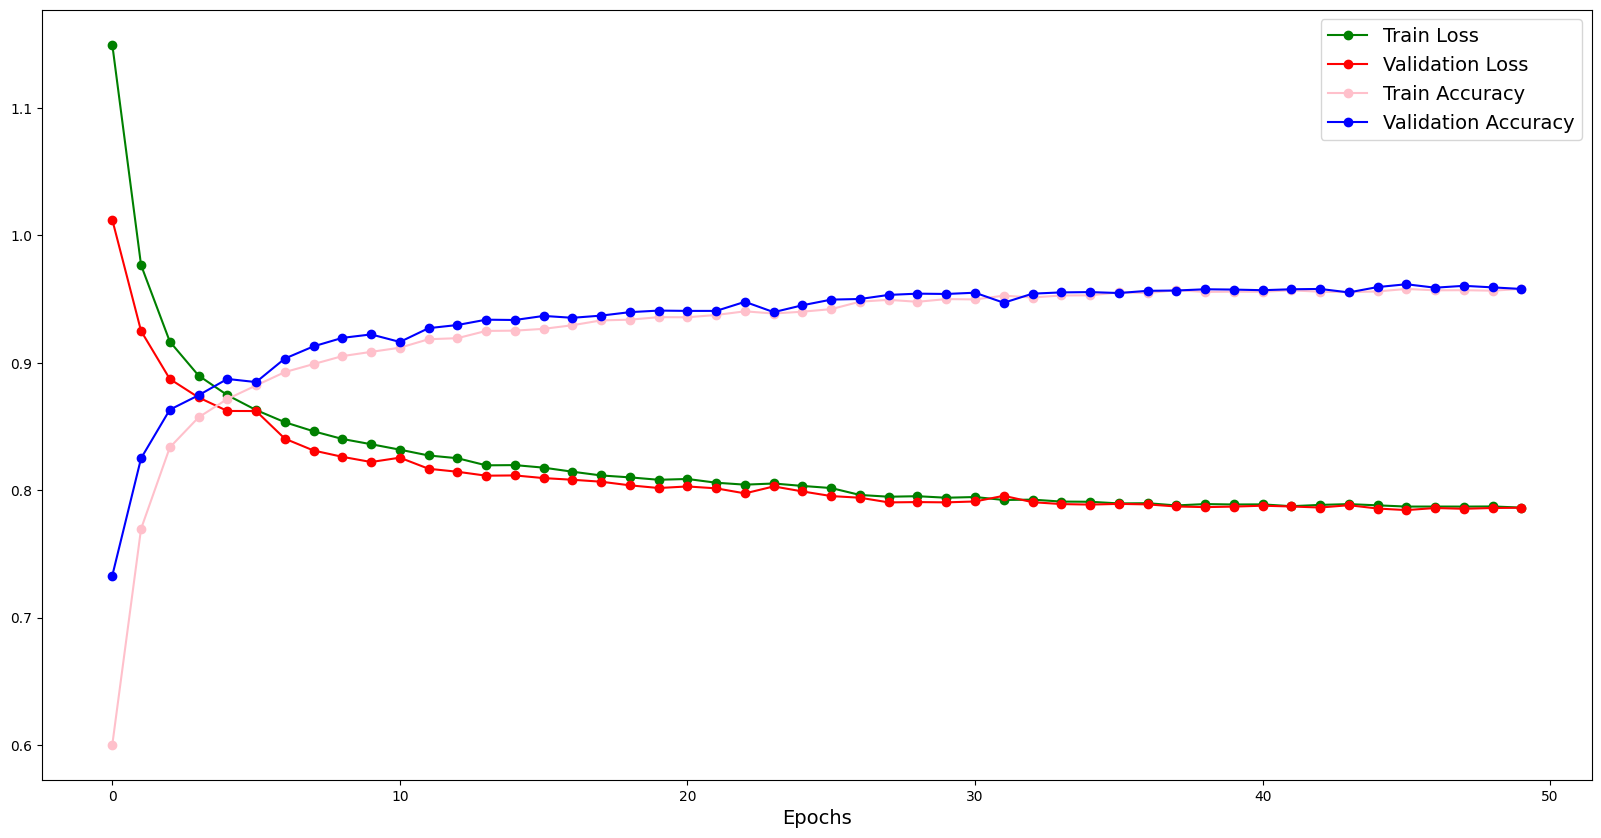

In [12]:
history = pickle.load(open("{x}_history.pickle".format(x = config['name']), "rb"))
plot_history(history, config['name'])

In [13]:
dict_ = pickle.load(open("{x}_prediction.pickle".format(x = config['name']), "rb"))
report = classification_report(dict_['y_true'] , dict_['y_pred'])
print(report)


              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      3030
         1.0       0.96      0.95      0.95      3030
         2.0       0.97      0.97      0.97      1414
         3.0       0.93      0.90      0.91       606

    accuracy                           0.96      8080
   macro avg       0.96      0.95      0.95      8080
weighted avg       0.96      0.96      0.96      8080



## SMOTE-Balanced Training

In [14]:
config['tr_path'] = 'Data/df_tr_smote.csv'
config['name'] = 'smote'

df_tr = pd.read_csv(config['tr_path'])

y = np.array(df_tr.iloc[:, -1])


mean = torch.tensor(np.mean(df_tr.iloc[: ,:-1], axis=0), dtype = torch.float32)
std = torch.tensor(np.std(df_tr.iloc[: ,:-1], axis=0) , dtype = torch.float32)
print(mean.shape , std.shape)

torch.Size([147]) torch.Size([147])


In [15]:
if not os.path.exists('smote_model.pt'):
  tr_dataset = MyDataset(path =config ['tr_path'] , mean = mean ,std = std , apply_transform = True)
  tr_loader = DataLoader(tr_dataset, batch_size=config['BATCH_SIZE'], shuffle=True)

  val_dataset = MyDataset(path = config['val_path'] , mean = mean ,std = std, apply_transform = True)
  val_loader = DataLoader(val_dataset, batch_size=config['BATCH_SIZE'], shuffle=True)

  X,Y = next(iter(tr_loader))
  print(X.shape , Y.shape)

  obj = Train_Eval(model=model, model_name=config['name'] ,device=device ,train_loader=tr_loader,
                 val_loader=val_loader, optimizer=optimizer, criterion=criterion, lr_scheduler= lr_scheduler)
  obj.run(config['EPOCHS'])
  obj.eval(df_tst, mean, std)


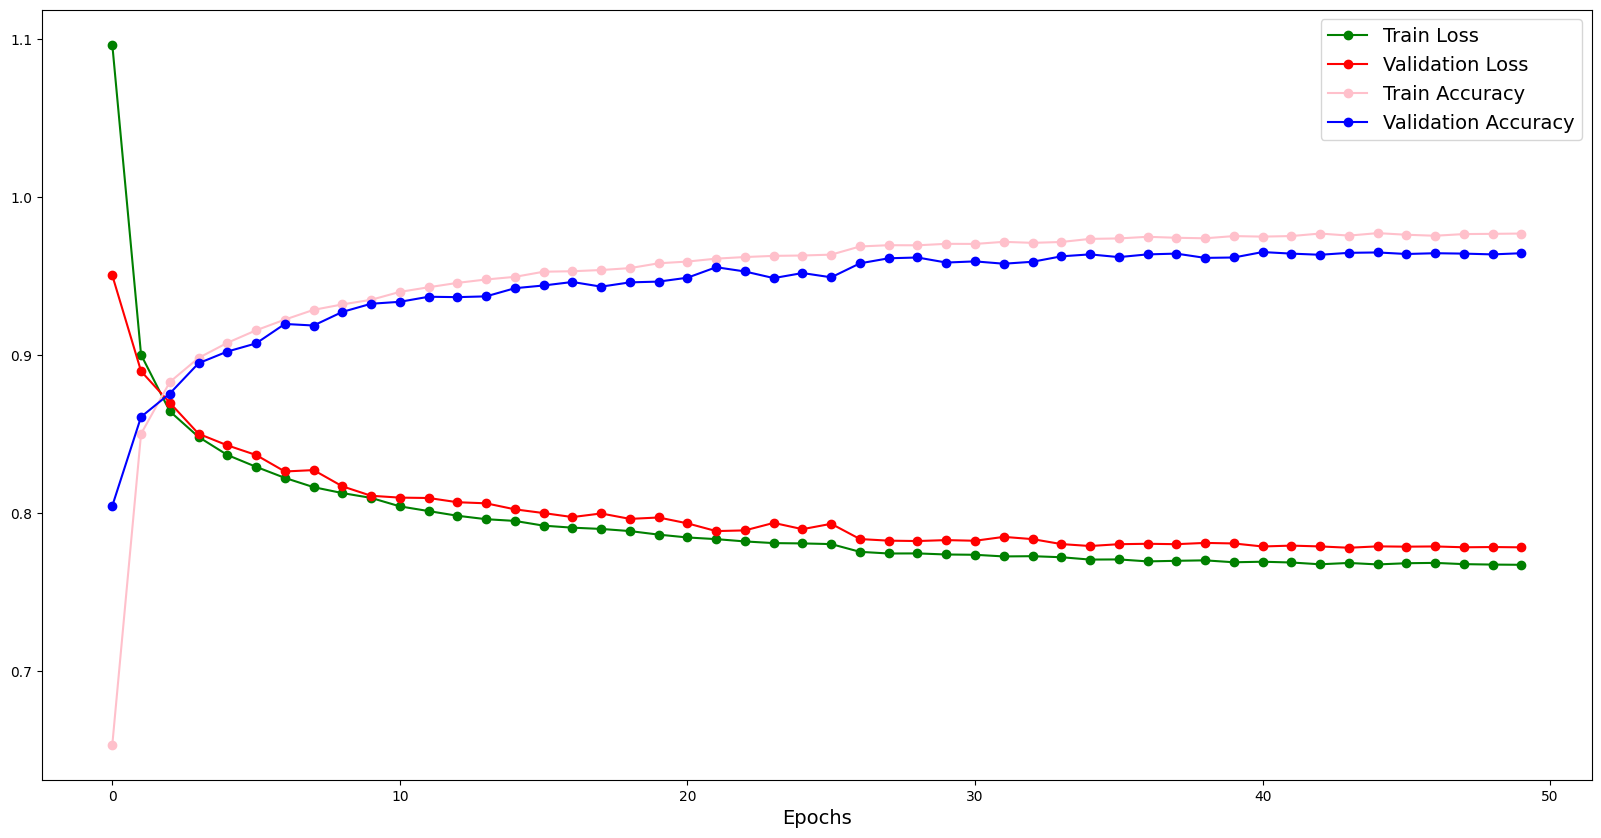

In [16]:
history = pickle.load(open("{x}_history.pickle".format(x = config['name']), "rb"))
plot_history(history, config['name'])

In [17]:
dict_ = pickle.load(open("{x}_prediction.pickle".format(x = config['name']), "rb"))
report = classification_report(dict_['y_true'] , dict_['y_pred'])
print(report)

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      3030
         1.0       0.97      0.94      0.96      3030
         2.0       0.97      0.98      0.98      1414
         3.0       0.90      0.96      0.93       606

    accuracy                           0.97      8080
   macro avg       0.96      0.97      0.96      8080
weighted avg       0.97      0.97      0.97      8080



## Adasyn-Data Training

In [18]:
config['tr_path'] = 'Data/df_tr_adasyn.csv'
config['name'] = 'adasyn'

df_tr = pd.read_csv(config['tr_path'])

y = np.array(df_tr.iloc[:, -1])


mean = torch.tensor(np.mean(df_tr.iloc[: ,:-1], axis=0), dtype = torch.float32)
std = torch.tensor(np.std(df_tr.iloc[: ,:-1], axis=0) , dtype = torch.float32)
print(mean.shape , std.shape)

torch.Size([147]) torch.Size([147])


In [19]:
if not os.path.exists('adasyn_model.pt'):
  tr_dataset = MyDataset(path =config ['tr_path'] , mean = mean ,std = std , apply_transform = True)
  tr_loader = DataLoader(tr_dataset, batch_size=config['BATCH_SIZE'], shuffle=True)

  val_dataset = MyDataset(path = config['val_path'] , mean = mean ,std = std, apply_transform = True)
  val_loader = DataLoader(val_dataset, batch_size=config['BATCH_SIZE'], shuffle=True)

  X,Y = next(iter(tr_loader))
  print(X.shape , Y.shape)

  obj = Train_Eval(model=model, model_name=config['name'] ,device=device ,train_loader=tr_loader,
                 val_loader=val_loader, optimizer=optimizer, criterion=criterion, lr_scheduler= lr_scheduler)
  obj.run(config['EPOCHS'])
  obj.eval(df_tst, mean, std)


torch.Size([32, 147]) torch.Size([32])

Epoch: 0


100%|██████████| 127/127 [00:00<00:00, 363.42it/s]


Epoch [0] --> LossTr: 1.1087    AccTr: 0.6405    lossVal : 0.9490     accVal : 0.8027

Detected network improvement, saving current model  "✅"

Epoch: 1


100%|██████████| 127/127 [00:00<00:00, 266.19it/s]


Epoch [1] --> LossTr: 0.9084    AccTr: 0.8408    lossVal : 0.8956     accVal : 0.8497

Detected network improvement, saving current model  "✅"

Epoch: 2


100%|██████████| 127/127 [00:00<00:00, 514.08it/s]


Epoch [2] --> LossTr: 0.8727    AccTr: 0.8738    lossVal : 0.8771     accVal : 0.8691

Detected network improvement, saving current model  "✅"

Epoch: 3


100%|██████████| 127/127 [00:00<00:00, 325.82it/s]


Epoch [3] --> LossTr: 0.8559    AccTr: 0.8901    lossVal : 0.8631     accVal : 0.8792

Detected network improvement, saving current model  "✅"

Epoch: 4


100%|██████████| 127/127 [00:00<00:00, 518.70it/s]


Epoch [4] --> LossTr: 0.8455    AccTr: 0.9006    lossVal : 0.8545     accVal : 0.8875


Epoch: 5


100%|██████████| 127/127 [00:00<00:00, 513.82it/s]


Epoch [5] --> LossTr: 0.8387    AccTr: 0.9060    lossVal : 0.8435     accVal : 0.9016

Detected network improvement, saving current model  "✅"

Epoch: 6


100%|██████████| 127/127 [00:00<00:00, 521.97it/s]


Epoch [6] --> LossTr: 0.8324    AccTr: 0.9122    lossVal : 0.8376     accVal : 0.9062


Epoch: 7


100%|██████████| 127/127 [00:00<00:00, 516.45it/s]


Epoch [7] --> LossTr: 0.8283    AccTr: 0.9166    lossVal : 0.8328     accVal : 0.9102

Detected network improvement, saving current model  "✅"

Epoch: 8


100%|██████████| 127/127 [00:00<00:00, 534.97it/s]


Epoch [8] --> LossTr: 0.8225    AccTr: 0.9221    lossVal : 0.8295     accVal : 0.9144


Epoch: 9


100%|██████████| 127/127 [00:00<00:00, 528.32it/s]


Epoch [9] --> LossTr: 0.8197    AccTr: 0.9248    lossVal : 0.8259     accVal : 0.9178


Epoch: 10


100%|██████████| 127/127 [00:00<00:00, 503.56it/s]


Epoch [10] --> LossTr: 0.8160    AccTr: 0.9285    lossVal : 0.8229     accVal : 0.9198


Epoch: 11


100%|██████████| 127/127 [00:00<00:00, 499.16it/s]


Epoch [11] --> LossTr: 0.8149    AccTr: 0.9293    lossVal : 0.8227     accVal : 0.9190

Detected network improvement, saving current model  "✅"

Epoch: 12


100%|██████████| 127/127 [00:00<00:00, 386.55it/s]


Epoch [12] --> LossTr: 0.8124    AccTr: 0.9311    lossVal : 0.8203     accVal : 0.9218


Epoch: 13


100%|██████████| 127/127 [00:00<00:00, 517.31it/s]


Epoch [13] --> LossTr: 0.8100    AccTr: 0.9341    lossVal : 0.8199     accVal : 0.9235


Epoch: 14


100%|██████████| 127/127 [00:00<00:00, 365.71it/s]


Epoch [14] --> LossTr: 0.8065    AccTr: 0.9376    lossVal : 0.8129     accVal : 0.9294


Epoch: 15


100%|██████████| 127/127 [00:00<00:00, 508.11it/s]


Epoch [15] --> LossTr: 0.8060    AccTr: 0.9390    lossVal : 0.8153     accVal : 0.9286


Epoch: 16


100%|██████████| 127/127 [00:00<00:00, 526.64it/s]


Epoch [16] --> LossTr: 0.8048    AccTr: 0.9391    lossVal : 0.8117     accVal : 0.9309

Detected network improvement, saving current model  "✅"

Epoch: 17


100%|██████████| 127/127 [00:00<00:00, 520.98it/s]


Epoch [17] --> LossTr: 0.8033    AccTr: 0.9407    lossVal : 0.8105     accVal : 0.9316


Epoch: 18


100%|██████████| 127/127 [00:00<00:00, 474.36it/s]


Epoch [18] --> LossTr: 0.8029    AccTr: 0.9409    lossVal : 0.8123     accVal : 0.9306


Epoch: 19


100%|██████████| 127/127 [00:00<00:00, 509.03it/s]


Epoch [19] --> LossTr: 0.8010    AccTr: 0.9427    lossVal : 0.8081     accVal : 0.9358


Epoch: 20


100%|██████████| 127/127 [00:00<00:00, 500.22it/s]


Epoch [20] --> LossTr: 0.7997    AccTr: 0.9441    lossVal : 0.8072     accVal : 0.9355


Epoch: 21


100%|██████████| 127/127 [00:00<00:00, 529.01it/s]


Epoch [21] --> LossTr: 0.7979    AccTr: 0.9464    lossVal : 0.8092     accVal : 0.9309


Epoch: 22


100%|██████████| 127/127 [00:00<00:00, 535.16it/s]


Epoch [22] --> LossTr: 0.7969    AccTr: 0.9472    lossVal : 0.8067     accVal : 0.9353


Epoch: 23


100%|██████████| 127/127 [00:00<00:00, 326.72it/s]


Epoch [23] --> LossTr: 0.7963    AccTr: 0.9471    lossVal : 0.8034     accVal : 0.9392


Epoch: 24


100%|██████████| 127/127 [00:00<00:00, 509.65it/s]


Epoch [24] --> LossTr: 0.7907    AccTr: 0.9535    lossVal : 0.8019     accVal : 0.9405


Epoch: 25


100%|██████████| 127/127 [00:00<00:00, 353.56it/s]


Epoch [25] --> LossTr: 0.7900    AccTr: 0.9538    lossVal : 0.8033     accVal : 0.9392


Epoch: 26


100%|██████████| 127/127 [00:00<00:00, 499.78it/s]


Epoch [26] --> LossTr: 0.7886    AccTr: 0.9552    lossVal : 0.7961     accVal : 0.9469

Detected network improvement, saving current model  "✅"

Epoch: 27


100%|██████████| 127/127 [00:00<00:00, 501.64it/s]


Epoch [27] --> LossTr: 0.7878    AccTr: 0.9564    lossVal : 0.7979     accVal : 0.9454


Epoch: 28


100%|██████████| 127/127 [00:00<00:00, 513.75it/s]


Epoch [28] --> LossTr: 0.7869    AccTr: 0.9571    lossVal : 0.7985     accVal : 0.9456


Epoch: 29


100%|██████████| 127/127 [00:00<00:00, 533.93it/s]


Epoch [29] --> LossTr: 0.7873    AccTr: 0.9560    lossVal : 0.7997     accVal : 0.9427


Epoch: 30


100%|██████████| 127/127 [00:00<00:00, 530.87it/s]


Epoch [30] --> LossTr: 0.7865    AccTr: 0.9576    lossVal : 0.7948     accVal : 0.9493


Epoch: 31


100%|██████████| 127/127 [00:00<00:00, 496.30it/s]


Epoch [31] --> LossTr: 0.7865    AccTr: 0.9570    lossVal : 0.7974     accVal : 0.9449


Epoch: 32


100%|██████████| 127/127 [00:00<00:00, 398.55it/s]


Epoch [32] --> LossTr: 0.7844    AccTr: 0.9596    lossVal : 0.7947     accVal : 0.9486


Epoch: 33


100%|██████████| 127/127 [00:00<00:00, 525.35it/s]


Epoch [33] --> LossTr: 0.7837    AccTr: 0.9606    lossVal : 0.7947     accVal : 0.9473


Epoch: 34


100%|██████████| 127/127 [00:00<00:00, 359.45it/s]


Epoch [34] --> LossTr: 0.7835    AccTr: 0.9609    lossVal : 0.7964     accVal : 0.9461


Epoch: 35


100%|██████████| 127/127 [00:00<00:00, 527.15it/s]


Epoch [35] --> LossTr: 0.7838    AccTr: 0.9604    lossVal : 0.7924     accVal : 0.9520


Epoch: 36


100%|██████████| 127/127 [00:00<00:00, 500.38it/s]


Epoch [36] --> LossTr: 0.7840    AccTr: 0.9597    lossVal : 0.7923     accVal : 0.9508


Epoch: 37


100%|██████████| 127/127 [00:00<00:00, 519.58it/s]


Epoch [37] --> LossTr: 0.7825    AccTr: 0.9619    lossVal : 0.7937     accVal : 0.9503


Epoch: 38


100%|██████████| 127/127 [00:00<00:00, 541.68it/s]


Epoch [38] --> LossTr: 0.7828    AccTr: 0.9616    lossVal : 0.7904     accVal : 0.9550


Epoch: 39


100%|██████████| 127/127 [00:00<00:00, 525.47it/s]


Epoch [39] --> LossTr: 0.7828    AccTr: 0.9614    lossVal : 0.7916     accVal : 0.9535


Epoch: 40


100%|██████████| 127/127 [00:00<00:00, 533.82it/s]


Epoch [40] --> LossTr: 0.7820    AccTr: 0.9619    lossVal : 0.7909     accVal : 0.9532


Epoch: 41


100%|██████████| 127/127 [00:00<00:00, 494.94it/s]


Epoch [41] --> LossTr: 0.7812    AccTr: 0.9632    lossVal : 0.7919     accVal : 0.9528


Epoch: 42


100%|██████████| 127/127 [00:00<00:00, 501.27it/s]


Epoch [42] --> LossTr: 0.7814    AccTr: 0.9629    lossVal : 0.7902     accVal : 0.9545


Epoch: 43


100%|██████████| 127/127 [00:00<00:00, 360.33it/s]


Epoch [43] --> LossTr: 0.7825    AccTr: 0.9617    lossVal : 0.7917     accVal : 0.9523


Epoch: 44


100%|██████████| 127/127 [00:00<00:00, 529.95it/s]


Epoch [44] --> LossTr: 0.7806    AccTr: 0.9635    lossVal : 0.7888     accVal : 0.9567


Epoch: 45


100%|██████████| 127/127 [00:00<00:00, 347.82it/s]


Epoch [45] --> LossTr: 0.7798    AccTr: 0.9648    lossVal : 0.7907     accVal : 0.9532


Epoch: 46


100%|██████████| 127/127 [00:00<00:00, 493.57it/s]


Epoch [46] --> LossTr: 0.7804    AccTr: 0.9638    lossVal : 0.7914     accVal : 0.9528


Epoch: 47


100%|██████████| 127/127 [00:00<00:00, 497.17it/s]


Epoch [47] --> LossTr: 0.7806    AccTr: 0.9643    lossVal : 0.7906     accVal : 0.9530


Epoch: 48


100%|██████████| 127/127 [00:00<00:00, 533.65it/s]


Epoch [48] --> LossTr: 0.7807    AccTr: 0.9636    lossVal : 0.7927     accVal : 0.9500


Epoch: 49


100%|██████████| 127/127 [00:00<00:00, 522.35it/s]


Epoch [49] --> LossTr: 0.7797    AccTr: 0.9646    lossVal : 0.7897     accVal : 0.9545

acc : 0.955941   
{0: 3030, 1: 3030, 2: 1414, 3: 606}


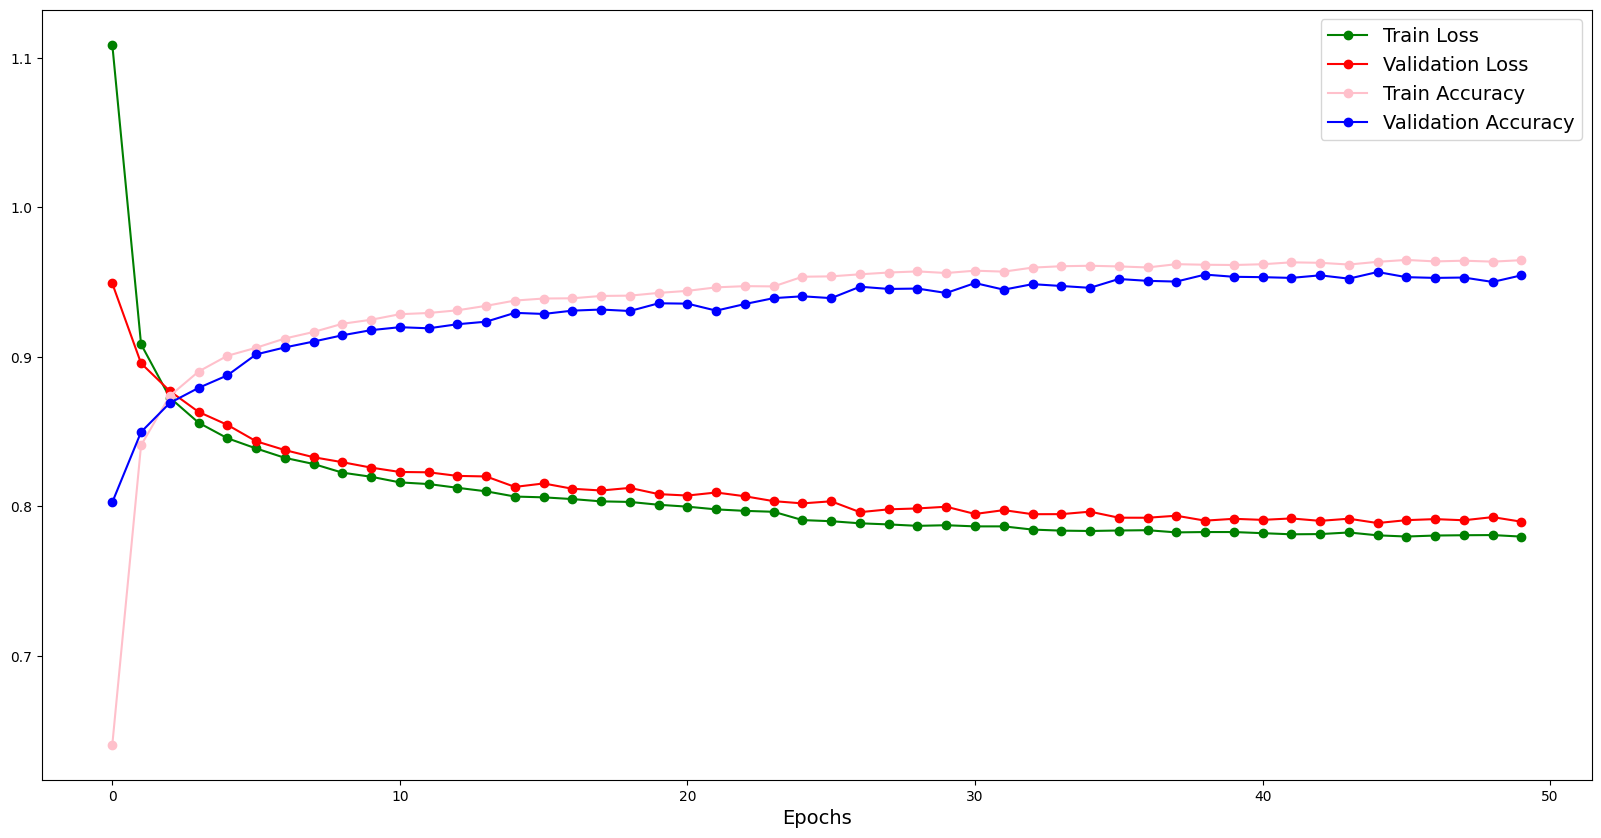

In [20]:
history = pickle.load(open("{x}_history.pickle".format(x = config['name']), "rb"))
plot_history(history, config['name'])

In [21]:
dict_ = pickle.load(open("{x}_prediction.pickle".format(x = config['name']), "rb"))
report = classification_report(dict_['y_true'] , dict_['y_pred'])
print(report)

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      3030
         1.0       0.97      0.91      0.94      3030
         2.0       0.96      0.98      0.97      1414
         3.0       0.84      0.96      0.90       606

    accuracy                           0.96      8080
   macro avg       0.93      0.96      0.95      8080
weighted avg       0.96      0.96      0.96      8080

